#4주차 과제
##fashion MNIST 데이터셋을 사용하여 의류 이미지를 분류하는 CNN 만들기

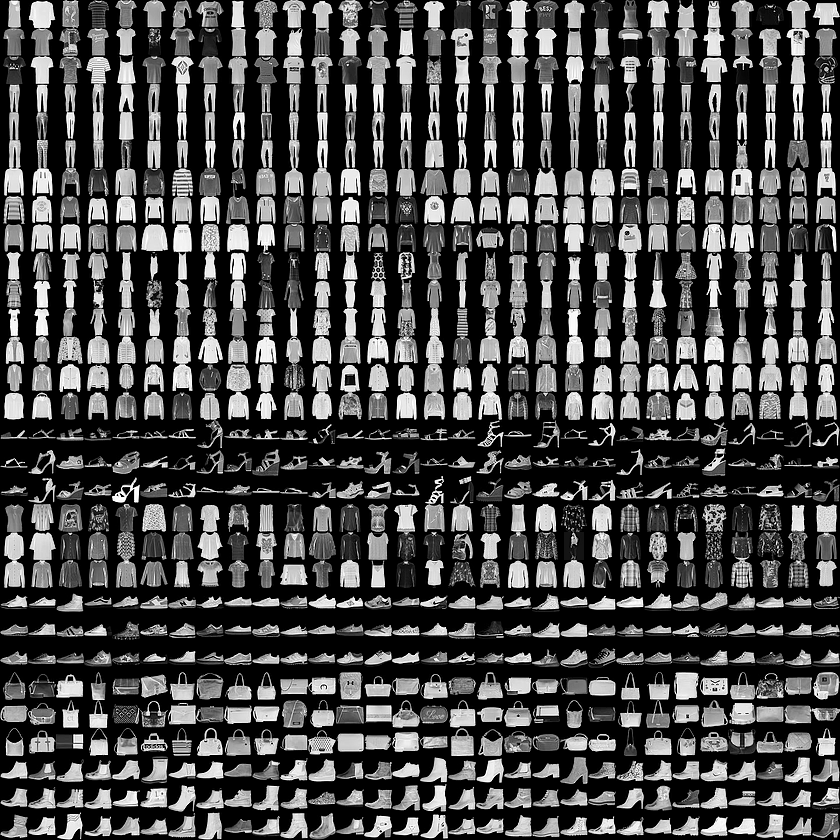

fashion MNIST 데이터셋은 운동화, 셔츠 등 다양한 의류 이미지와 그 종류 라벨로 구성된 computer vision 데이터  
**한 이미지는 28*28 이며 10가지의 종류로 분류된다**

In [ ]:
#필요한 라이브러리 설치
import torch #파이토치
from torch import nn, optim
import torchvision.datasets as dsets #MNIST 데이터셋을 불러옴
import torchvision.transforms as transforms #이미지 변환 툴
import torch.nn.init #텐서에 초기값을 줌

import matplotlib.pyplot as plt
import numpy as np

In [ ]:
#연산 방법 설정
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# 랜덤 시드 고정
torch.manual_seed(777)

# GPU 사용 가능일 경우 랜덤 시드 고정
if device == 'cuda':
    torch.cuda.manual_seed_all(777)

In [ ]:
#데이터 불러오기
trainset = dsets.FashionMNIST(
    root      = './.data/', 
    train     = True,
    download  = True,
    transform = transforms.ToTensor()
)

testset = dsets.FashionMNIST(
    root      = './.data/', 
    train     = False,
    download  = True,
    transform = transforms.ToTensor()
)

  0%|          | 0/26421880 [00:00<?, ?it/s]

Extracting ./.data/FashionMNIST/raw/train-images-idx3-ubyte.gz to ./.data/FashionMNIST/raw



  0%|          | 0/29515 [00:00<?, ?it/s]

Extracting ./.data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./.data/FashionMNIST/raw



  0%|          | 0/4422102 [00:00<?, ?it/s]

Extracting ./.data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./.data/FashionMNIST/raw



  0%|          | 0/5148 [00:00<?, ?it/s]

Extracting ./.data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./.data/FashionMNIST/raw



In [ ]:
print(len(trainset))
print(len(testset))

60000
10000


In [ ]:
#하이퍼 파라미터 설정
learning_rate = 0.001

training_epochs1 = 10
training_epochs2 = 20
batch_size = 100

In [ ]:
#데이터로더
train_loader = torch.utils.data.DataLoader(
    dataset     = trainset,
    batch_size  = batch_size,
    shuffle     = True,
)

test_loader = torch.utils.data.DataLoader(
    dataset     = testset,
    batch_size  = batch_size,
    shuffle     = True,
)

In [ ]:
#라벨 정의 함수 설정
def output_label(label):
    output_mapping = {
                 0: "T-shirt/Top",
                 1: "Trouser",
                 2: "Pullover",
                 3: "Dress",
                 4: "Coat", 
                 5: "Sandal", 
                 6: "Shirt",
                 7: "Sneaker",
                 8: "Bag",
                 9: "Ankle Boot"
                 }
    input = (label.item() if type(label) == torch.Tensor else label)
    return output_mapping[input]

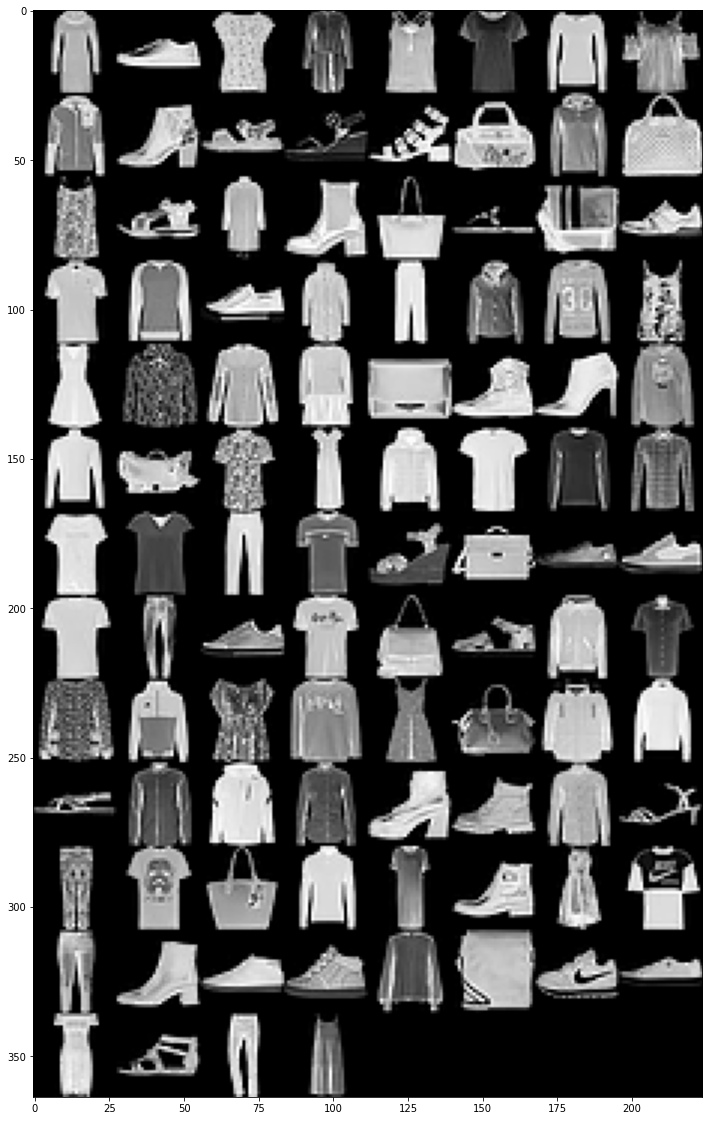

Dress, Sneaker, T-shirt/Top, Dress, T-shirt/Top, T-shirt/Top, Pullover, Shirt, Coat, Ankle Boot, Sandal, Sandal, Sandal, Bag, Pullover, Bag, T-shirt/Top, Sandal, Coat, Ankle Boot, Bag, Sandal, Bag, Sneaker, T-shirt/Top, Pullover, Sneaker, Coat, Trouser, Coat, Pullover, T-shirt/Top, Dress, Shirt, Shirt, Dress, Bag, Ankle Boot, Ankle Boot, Pullover, Pullover, Bag, Shirt, Dress, Coat, T-shirt/Top, Pullover, Shirt, T-shirt/Top, Shirt, Trouser, T-shirt/Top, Sandal, Bag, Sneaker, Sneaker, T-shirt/Top, Trouser, Sneaker, T-shirt/Top, Bag, Sandal, Coat, Shirt, Shirt, Coat, T-shirt/Top, Pullover, Dress, Bag, Coat, Pullover, Sandal, Shirt, Coat, Shirt, Ankle Boot, Ankle Boot, Shirt, Sandal, Trouser, T-shirt/Top, Bag, Pullover, Dress, Ankle Boot, Dress, Pullover, Trouser, Ankle Boot, Sneaker, Sneaker, Shirt, Bag, Sneaker, Sneaker, Dress, Sandal, Trouser, Dress, 

In [ ]:
#데이터(이미지) 확인해보기
from torchvision import utils

dataiter       = iter(train_loader)   # iter함수로 iteration 객체 가져오기
images, labels = next(dataiter)   # next함수로 다음 배치 1개 갖고오기

img   = utils.make_grid(images, padding=0)
npimg = img.numpy()
plt.figure(figsize=(15, 20))
plt.imshow(np.transpose(npimg, (1,2,0)))
plt.show()

for i, label in enumerate(labels):
    print(output_label(label), end=", ")

In [ ]:
#텐서 사이즈 확인하기
print(type(images), type(labels))
print(images.shape, labels.shape)

<class 'torch.Tensor'> <class 'torch.Tensor'>
torch.Size([100, 1, 28, 28]) torch.Size([100])


**#(batch size, channel, height, weight)**

#CNN Modeling

##순서 : convolution - batch normalization - activation - dropout - pooling

#처음 고안한 모델
first layer (1->32)  
second layer (32->64)  
third layer (64->128)  
fourth layer (128->256)  
fifth layer(fully-connected layer1, 3 * 3 * 256 -> 625)  
sixth layer(fully-connected layer2, 625 -> 135)  
seventh layer(fully-connected layer3, 135 -> 10) 

합성곱 층 활성화 함수로는 ReLU 함수를 사용했고 풀링 층에서는 max pooling을 사용함  
fully-connected layer에서 가중치 초기화 방법으로 He initialization을 사용하였고 0.5 rate로 dropout 진행  
loss function으로 CrossEntropy, optimizer로 Adam 사용

##첫번째 시도 Accuracy: 0.9104
위에서 만들 모델을 lr = 0.001, epoch = 10으로 training
##두번째 시도 Accuracy: 0.9134
epoch = 20으로 변경하여 training
##세번째 시도 Accuracy: 0.9078
epoch = 20일때 정확도가 더 높아 이를 고정하고, 합성곱 층에서 배치 정규화 진행
##네번째 시도 Accuracy: 0.9192
정확도가 낮아졌지만, 그냥 배치정규화를 진행하고 dropout rate를 0.5에서 0.7로 변경해보았다
##다섯번째 시도 Accuracy: 0.9251
drop out rate를 변경했더니 정확도가 높아져서 이를 고정하고 풀링층에서 max pooling 대신 average pooling을 진행해보았다
-> 가장 정확도가 높았다

###합성곱층과 풀링 선언

In [ ]:
#첫번째 합성곱층 구현
conv1 = nn.Conv2d(1, 32, 3, padding=1)
print(conv1)

Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))


In [ ]:
#두번째 합성곱층 구현
conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
print(conv2)

Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))


In [ ]:
#세번째 합성곱층 구현
conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
print(conv3)

Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))


In [ ]:
#네번째 합성곱층 구현
conv4 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
print(conv4)

Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))


In [ ]:
#맥스풀링 구현(1)
pool1 = nn.MaxPool2d(2)
print(pool1)

MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)


In [ ]:
#맥스풀링 구현(2)
pool2 = nn.MaxPool2d(2, padding = 1)
print(pool2)

MaxPool2d(kernel_size=2, stride=2, padding=1, dilation=1, ceil_mode=False)


###구현체 연결

In [ ]:
# 배치 크기 × 채널 × 높이(height) × 너비(widht)의 크기의 텐서를 선언
inputs = torch.Tensor(100, 1, 28, 28)
print('텐서의 크기 : {}'.format(inputs.shape))

텐서의 크기 : torch.Size([100, 1, 28, 28])


In [ ]:
out = conv1(inputs)
print(out.shape)

torch.Size([100, 32, 28, 28])


In [ ]:
out = pool1(out)
print(out.shape)

torch.Size([100, 32, 14, 14])


In [ ]:
out = conv2(out)
print(out.shape)

torch.Size([100, 64, 14, 14])


In [ ]:
out = pool1(out)
print(out.shape)

torch.Size([100, 64, 7, 7])


In [ ]:
out = conv3(out)
print(out.shape)

torch.Size([100, 128, 7, 7])


In [ ]:
out = pool2(out)
print(out.shape)

torch.Size([100, 128, 4, 4])


In [ ]:
out = conv4(out)
print(out.shape)

torch.Size([100, 256, 4, 4])


In [ ]:
out = pool2(out)
print(out.shape)

torch.Size([100, 256, 3, 3])


In [ ]:
#첫 번째 차원인 배치 차원은 그대로 두고 나머지 펼치기
out = out.view(out.size(0), -1) 
print(out.shape)

torch.Size([100, 2304])


**텐서 조작하기(Tensor Manipulation)**  
**뷰(View)** : 원소의 수를 유지하면서 텐서의 크기 변경  
파이토치 텐서의 뷰(View)는 넘파이에서의 리쉐이프(Reshape)와 같은 역할  
기본적으로 변경 전과 변경 후의 텐서 안의 원소의 개수가 유지되어야 한다 사이즈가 -1로 설정되면 다른 차원으로부터 해당 값을 유추한다  
[출처] https://wikidocs.net/52846

In [ ]:
#첫번째 전결합층(Fully_connected layer) 통과
fc1 = nn.Linear(2304, 625) # input_dim = 2304, output_dim = 625
out = fc1(out)
print(out.shape)

torch.Size([100, 625])


In [ ]:
#두번째 전결합층(Fully_connected layer) 통과
fc2 = nn.Linear(625, 135) # input_dim = 625, output_dim = 135
out = fc2(out)
print(out.shape)

torch.Size([100, 135])


In [ ]:
#세번째 전결합층(Fully_connected layer) 통과
fc3 = nn.Linear(135, 10) # input_dim = 135, output_dim = 10
out = fc3(out)
print(out.shape)

torch.Size([100, 10])


###class로 모델 구현

In [ ]:
class CNN(torch.nn.Module):

    def __init__(self):
        super(CNN, self).__init__()
        self.keep_prob = 0.5

        # first layer (1->32)
        self.layer1 = torch.nn.Sequential(
            torch.nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(kernel_size=2, stride=2))
        
        # second layer (32->64)
        self.layer2 = torch.nn.Sequential(
            torch.nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(kernel_size=2, stride=2))
        
        # third layer (64->128)
        self.layer3 = torch.nn.Sequential(
            torch.nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(kernel_size=2, stride=2, padding=1))
        
        # fourth layer (128->256)
        self.layer4 = torch.nn.Sequential(
            torch.nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(kernel_size=2, stride=2, padding=1))

        # fifth layer(fully-connected layer1, 3 * 3 * 256 -> 625)
        self.fc1 = torch.nn.Linear(3 * 3 * 256, 625, bias=True)
        torch.nn.init.kaiming_uniform(self.fc1.weight)   # 가중치 초기화
        self.layer5 = torch.nn.Sequential(
            self.fc1,
            torch.nn.ReLU(),
            torch.nn.Dropout(p=1 - self.keep_prob))
        
        # sixth layer(fully-connected layer2, 625 -> 135)
        self.fc2 = torch.nn.Linear(625, 135, bias=True)
        torch.nn.init.kaiming_uniform(self.fc2.weight)   # 가중치 초기화
        self.layer6 = torch.nn.Sequential(
            self.fc1,
            torch.nn.ReLU(),
            torch.nn.Dropout(p=1 - self.keep_prob))
        
        # seventh layer(fully-connected layer3, 135 -> 10) 
        self.fc3 = torch.nn.Linear(135, 10, bias=True)
        torch.nn.init.kaiming_uniform(self.fc3.weight)

    def forward(self, x):
        out = self.layer1(x)   # first layer 통과
        out = self.layer2(out)   # second layer 통과
        out = self.layer3(out)   # third layer 통과
        out = self.layer4(out)   # fourth layer 통과
        out = out.view(out.size(0), -1)   # fully-connected layer를 위해서 Flatten
        out = self.fc1(out)   # fifth layer 통과
        out = self.fc2(out)   # sixth layer 통과
        out = self.fc3(out)   # seventh layer 통과
        return out

##training

In [ ]:
model1 = CNN().to(device)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:33: UserWarning: nn.init.kaiming_uniform is now deprecated in favor of nn.init.kaiming_uniform_.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:41: UserWarning: nn.init.kaiming_uniform is now deprecated in favor of nn.init.kaiming_uniform_.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: UserWarning: nn.init.kaiming_uniform is now deprecated in favor of nn.init.kaiming_uniform_.


In [ ]:
print(model1)

CNN(
  (layer1): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer3): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=1, dilation=1, ceil_mode=False)
  )
  (layer4): Sequential(
    (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=1, dilation=1, ceil_mode=False)
  )
  (fc1): Linear(in_features=2304, out_features=625, bias=True)
  (layer5): Sequential(
    (0): Linear(in_features=2304, out_features=625, bias=True)
    (1): ReLU()
    (2): Dropou

#첫번째시도

epoch = 10으로 training

In [ ]:
#loss function 생성
loss  = nn.CrossEntropyLoss().to(device)

#앞서 생성한 model의 parameter update 해주는 optimizer; learning rate = 0.001
optimizer = optim.Adam(model1.parameters(), lr= learning_rate)

In [ ]:
def training_model(model, data, epochs):
  total_batch = len(data)
  for epoch in range(epochs):
    avg_cost = 0

    for X, Y in data:  #data_loader에 배치들이 저장되어 있음. 한 iteration당 한 개의 배치를 꺼내와서 사용
        X = X.to(device)   #이미지
        Y = Y.to(device)   #레이블(해당 이미지가 뜻하는 숫자)

        optimizer.zero_grad()   #지난 iteration에서 계산했던 기울기 초기화
        hypothesis = model(X)   #순전파 과정으로 예측값 도출
        cost = loss(hypothesis, Y)   #예측값과 실제값을 비교한 loss
        cost.backward()   #역전파, 기울기 계산
        optimizer.step()   #optimizer로 가중치 갱신

        avg_cost += cost / total_batch

    print('[Epoch: {:>4}] cost = {:>.9}'.format(epoch + 1, avg_cost))

In [ ]:
#모델 학습
training_model(model = model1, data = train_loader, epochs = training_epochs1)

[Epoch:    1] cost = 0.476350993
[Epoch:    2] cost = 0.279135734
[Epoch:    3] cost = 0.23215735
[Epoch:    4] cost = 0.20473592
[Epoch:    5] cost = 0.180793896
[Epoch:    6] cost = 0.162792146
[Epoch:    7] cost = 0.141505688
[Epoch:    8] cost = 0.127357543
[Epoch:    9] cost = 0.109507099
[Epoch:   10] cost = 0.0954889357


In [ ]:
#test 데이터 사용하여 모델 성능(정확도)확인
correct = 0

with torch.no_grad():
    model1.eval()
    for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model1(data)
            
            pred = output.max(1, keepdim=True)[1]
            # eq() 함수는 값이 일치하면 1을, 아니면 0을 출력.
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_accuracy = correct / len(test_loader.dataset)
    print('Accuracy:', test_accuracy)

Accuracy: 0.9104


##두번째 시도

epoch를 10에서 20으로 변경

In [ ]:
#모델 학습
training_model(model = model1, data = train_loader, epochs = training_epochs2)

[Epoch:    1] cost = 0.476207912
[Epoch:    2] cost = 0.28040719
[Epoch:    3] cost = 0.237798557
[Epoch:    4] cost = 0.209189102
[Epoch:    5] cost = 0.184092999
[Epoch:    6] cost = 0.165644422
[Epoch:    7] cost = 0.145466596
[Epoch:    8] cost = 0.131090209
[Epoch:    9] cost = 0.113004029
[Epoch:   10] cost = 0.0977361426
[Epoch:   11] cost = 0.0910203233
[Epoch:   12] cost = 0.0835265592
[Epoch:   13] cost = 0.0689802095
[Epoch:   14] cost = 0.062981613
[Epoch:   15] cost = 0.0583972484
[Epoch:   16] cost = 0.0519783385
[Epoch:   17] cost = 0.0505267866
[Epoch:   18] cost = 0.0468995273
[Epoch:   19] cost = 0.0408954807
[Epoch:   20] cost = 0.040358156


In [ ]:
#test 데이터 사용하여 모델 성능(정확도)확인
correct = 0

with torch.no_grad():
    model1.eval()
    for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model1(data)
            
            pred = output.max(1, keepdim=True)[1]
            # eq() 함수는 값이 일치하면 1을, 아니면 0을 출력.
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_accuracy = correct / len(test_loader.dataset)
    print('Accuracy:', test_accuracy)

Accuracy: 0.9134


epoch가 20일때 정확도가 더 높아 epoch를 10이 아닌 20으로 설정

##세번째 시도

합성곱층에 배치 정규화를 진행

##순서 : convolution - batch normalization - activation - dropout - pooling

In [ ]:
class CNN1(torch.nn.Module):

    def __init__(self):
        super(CNN1, self).__init__()
        self.keep_prob = 0.5

        # first layer (1->32)
        self.layer1 = torch.nn.Sequential(
            torch.nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1),
            torch.nn.BatchNorm2d(32),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(kernel_size=2, stride=2))
        
        # second layer (32->64)
        self.layer2 = torch.nn.Sequential(
            torch.nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            torch.nn.BatchNorm2d(64),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(kernel_size=2, stride=2))
        
        # third layer (64->128)
        self.layer3 = torch.nn.Sequential(
            torch.nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            torch.nn.BatchNorm2d(128),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(kernel_size=2, stride=2, padding=1))
        
        # fourth layer (128->256)
        self.layer4 = torch.nn.Sequential(
            torch.nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            torch.nn.BatchNorm2d(256),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(kernel_size=2, stride=2, padding=1))

        # fifth layer(fully-connected layer1, 3 * 3 * 256 -> 625)
        self.fc1 = torch.nn.Linear(3 * 3 * 256, 625, bias=True)
        torch.nn.init.kaiming_uniform(self.fc1.weight)   # 가중치 초기화
        self.layer5 = torch.nn.Sequential(
            self.fc1,
            torch.nn.ReLU(),
            torch.nn.Dropout(p=1 - self.keep_prob))
        
        # sixth layer(fully-connected layer2, 625 -> 135)
        self.fc2 = torch.nn.Linear(625, 135, bias=True)
        torch.nn.init.kaiming_uniform(self.fc2.weight)   # 가중치 초기화
        self.layer6 = torch.nn.Sequential(
            self.fc1,
            torch.nn.ReLU(),
            torch.nn.Dropout(p=1 - self.keep_prob))
        
        # seventh layer(fully-connected layer3, 135 -> 10) 
        self.fc3 = torch.nn.Linear(135, 10, bias=True)
        torch.nn.init.kaiming_uniform(self.fc3.weight)

    def forward(self, x):
        out = self.layer1(x)   # first layer 통과
        out = self.layer2(out)   # second layer 통과
        out = self.layer3(out)   # third layer 통과
        out = self.layer4(out)   # fourth layer 통과
        out = out.view(out.size(0), -1)   # fully-connected layer를 위해서 Flatten
        out = self.fc1(out)   # fifth layer 통과
        out = self.fc2(out)   # sixth layer 통과
        out = self.fc3(out)   # seventh layer 통과
        return out

In [ ]:
model2 = CNN1().to(device)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:37: UserWarning: nn.init.kaiming_uniform is now deprecated in favor of nn.init.kaiming_uniform_.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:45: UserWarning: nn.init.kaiming_uniform is now deprecated in favor of nn.init.kaiming_uniform_.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:53: UserWarning: nn.init.kaiming_uniform is now deprecated in favor of nn.init.kaiming_uniform_.


In [ ]:
#loss function 생성
loss  = nn.CrossEntropyLoss().to(device)

#앞서 생성한 model의 parameter update 해주는 optimizer; learning rate = 0.001
optimizer = optim.Adam(model2.parameters(), lr= learning_rate)

In [ ]:
#모델 학습
training_model(model = model2, data = train_loader, epochs = training_epochs2)

[Epoch:    1] cost = 0.775212109
[Epoch:    2] cost = 0.29555741
[Epoch:    3] cost = 0.255652934
[Epoch:    4] cost = 0.228783548
[Epoch:    5] cost = 0.206341952
[Epoch:    6] cost = 0.189120919
[Epoch:    7] cost = 0.164217144
[Epoch:    8] cost = 0.143104732
[Epoch:    9] cost = 0.126681507
[Epoch:   10] cost = 0.129050702
[Epoch:   11] cost = 0.0958539471
[Epoch:   12] cost = 0.0903052688
[Epoch:   13] cost = 0.0825240836
[Epoch:   14] cost = 0.0692765415
[Epoch:   15] cost = 0.0623806976
[Epoch:   16] cost = 0.223550126
[Epoch:   17] cost = 0.0467266329
[Epoch:   18] cost = 0.033862222
[Epoch:   19] cost = 0.044826746
[Epoch:   20] cost = 0.0409967303


In [ ]:
#test 데이터 사용하여 모델 성능(정확도)확인
correct = 0

with torch.no_grad():
    model2.eval()
    for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model2(data)
            
            pred = output.max(1, keepdim=True)[1]
            # eq() 함수는 값이 일치하면 1을, 아니면 0을 출력.
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_accuracy = correct / len(test_loader.dataset)
    print('Accuracy:', test_accuracy)

Accuracy: 0.9078


배치정규화를 진행했더니 정확도가 더 떨어졌다  
그렇지만 그냥 진행하고 drop out rate를 변경해보기로 했다

#네번째 시도

배치 정규화 진행하고 drop out rate를 0.5에서 0.7로 변경  
즉, 50% 대신 70% 사용

In [ ]:
class CNN2(torch.nn.Module):

    def __init__(self):
        super(CNN2, self).__init__()
        self.keep_prob = 0.3

        # first layer (1->32)
        self.layer1 = torch.nn.Sequential(
            torch.nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1),
            torch.nn.BatchNorm2d(32),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(kernel_size=2, stride=2))
        
        # second layer (32->64)
        self.layer2 = torch.nn.Sequential(
            torch.nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            torch.nn.BatchNorm2d(64),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(kernel_size=2, stride=2))
        
        # third layer (64->128)
        self.layer3 = torch.nn.Sequential(
            torch.nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            torch.nn.BatchNorm2d(128),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(kernel_size=2, stride=2, padding=1))
        
        # fourth layer (128->256)
        self.layer4 = torch.nn.Sequential(
            torch.nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            torch.nn.BatchNorm2d(256),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(kernel_size=2, stride=2, padding=1))

        # fifth layer(fully-connected layer1, 3 * 3 * 256 -> 625)
        self.fc1 = torch.nn.Linear(3 * 3 * 256, 625, bias=True)
        torch.nn.init.kaiming_uniform(self.fc1.weight)   # 가중치 초기화
        self.layer5 = torch.nn.Sequential(
            self.fc1,
            torch.nn.ReLU(),
            torch.nn.Dropout(p=1 - self.keep_prob))
        
        # sixth layer(fully-connected layer2, 625 -> 135)
        self.fc2 = torch.nn.Linear(625, 135, bias=True)
        torch.nn.init.kaiming_uniform(self.fc2.weight)   # 가중치 초기화
        self.layer6 = torch.nn.Sequential(
            self.fc1,
            torch.nn.ReLU(),
            torch.nn.Dropout(p=1 - self.keep_prob))
        
        # seventh layer(fully-connected layer3, 135 -> 10) 
        self.fc3 = torch.nn.Linear(135, 10, bias=True)
        torch.nn.init.kaiming_uniform(self.fc3.weight)

    def forward(self, x):
        out = self.layer1(x)   # first layer 통과
        out = self.layer2(out)   # second layer 통과
        out = self.layer3(out)   # third layer 통과
        out = self.layer4(out)   # fourth layer 통과
        out = out.view(out.size(0), -1)   # fully-connected layer를 위해서 Flatten
        out = self.fc1(out)   # fifth layer 통과
        out = self.fc2(out)   # sixth layer 통과
        out = self.fc3(out)   # seventh layer 통과
        return out

In [ ]:
model3 = CNN2().to(device)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:37: UserWarning: nn.init.kaiming_uniform is now deprecated in favor of nn.init.kaiming_uniform_.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:45: UserWarning: nn.init.kaiming_uniform is now deprecated in favor of nn.init.kaiming_uniform_.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:53: UserWarning: nn.init.kaiming_uniform is now deprecated in favor of nn.init.kaiming_uniform_.


In [ ]:
#loss function 생성
loss  = nn.CrossEntropyLoss().to(device)

#앞서 생성한 model의 parameter update 해주는 optimizer; learning rate = 0.001
optimizer = optim.Adam(model3.parameters(), lr= learning_rate)

In [ ]:
#모델 학습
training_model(model = model3, data = train_loader, epochs = training_epochs2)

[Epoch:    1] cost = 0.773511171
[Epoch:    2] cost = 0.2972835
[Epoch:    3] cost = 0.256099641
[Epoch:    4] cost = 0.231341988
[Epoch:    5] cost = 0.202703297
[Epoch:    6] cost = 0.186499849
[Epoch:    7] cost = 0.182376847
[Epoch:    8] cost = 0.140411988
[Epoch:    9] cost = 0.127330467
[Epoch:   10] cost = 0.114336804
[Epoch:   11] cost = 0.101564899
[Epoch:   12] cost = 0.090317823
[Epoch:   13] cost = 0.0874486938
[Epoch:   14] cost = 0.0800022408
[Epoch:   15] cost = 0.0553573295
[Epoch:   16] cost = 0.0566416495
[Epoch:   17] cost = 0.0531094894
[Epoch:   18] cost = 0.0474080257
[Epoch:   19] cost = 0.131731883
[Epoch:   20] cost = 0.0336779058


In [ ]:
#test 데이터 사용하여 모델 성능(정확도)확인
correct = 0

with torch.no_grad():
    model3.eval()
    for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model3(data)
            
            pred = output.max(1, keepdim=True)[1]
            # eq() 함수는 값이 일치하면 1을, 아니면 0을 출력.
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_accuracy = correct / len(test_loader.dataset)
    print('Accuracy:', test_accuracy)

Accuracy: 0.9192


drop out rate를 변경했더니 정확도가 다시 높아졌다

#다섯번째 시도

풀링층에서 max pooling이 아닌 average pooling을 진행해보았다

In [ ]:
class CNN3(torch.nn.Module):

    def __init__(self):
        super(CNN3, self).__init__()
        self.keep_prob = 0.3

        # first layer (1->32)
        self.layer1 = torch.nn.Sequential(
            torch.nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1),
            torch.nn.BatchNorm2d(32),
            torch.nn.ReLU(),
            torch.nn.AvgPool2d(kernel_size=2, stride=2))
        
        # second layer (32->64)
        self.layer2 = torch.nn.Sequential(
            torch.nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            torch.nn.BatchNorm2d(64),
            torch.nn.ReLU(),
            torch.nn.AvgPool2d(kernel_size=2, stride=2))
        
        # third layer (64->128)
        self.layer3 = torch.nn.Sequential(
            torch.nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            torch.nn.BatchNorm2d(128),
            torch.nn.ReLU(),
            torch.nn.AvgPool2d(kernel_size=2, stride=2, padding=1))
        
        # fourth layer (128->256)
        self.layer4 = torch.nn.Sequential(
            torch.nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            torch.nn.BatchNorm2d(256),
            torch.nn.ReLU(),
            torch.nn.AvgPool2d(kernel_size=2, stride=2, padding=1))

        # fifth layer(fully-connected layer1, 3 * 3 * 256 -> 625)
        self.fc1 = torch.nn.Linear(3 * 3 * 256, 625, bias=True)
        torch.nn.init.kaiming_uniform(self.fc1.weight)   # 가중치 초기화
        self.layer5 = torch.nn.Sequential(
            self.fc1,
            torch.nn.ReLU(),
            torch.nn.Dropout(p=1 - self.keep_prob))
        
        # sixth layer(fully-connected layer2, 625 -> 135)
        self.fc2 = torch.nn.Linear(625, 135, bias=True)
        torch.nn.init.kaiming_uniform(self.fc2.weight)   # 가중치 초기화
        self.layer6 = torch.nn.Sequential(
            self.fc1,
            torch.nn.ReLU(),
            torch.nn.Dropout(p=1 - self.keep_prob))
        
        # seventh layer(fully-connected layer3, 135 -> 10) 
        self.fc3 = torch.nn.Linear(135, 10, bias=True)
        torch.nn.init.kaiming_uniform(self.fc3.weight)

    def forward(self, x):
        out = self.layer1(x)   # first layer 통과
        out = self.layer2(out)   # second layer 통과
        out = self.layer3(out)   # third layer 통과
        out = self.layer4(out)   # fourth layer 통과
        out = out.view(out.size(0), -1)   # fully-connected layer를 위해서 Flatten
        out = self.fc1(out)   # fifth layer 통과
        out = self.fc2(out)   # sixth layer 통과
        out = self.fc3(out)   # seventh layer 통과
        return out

In [ ]:
model4 = CNN3().to(device)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:37: UserWarning: nn.init.kaiming_uniform is now deprecated in favor of nn.init.kaiming_uniform_.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:45: UserWarning: nn.init.kaiming_uniform is now deprecated in favor of nn.init.kaiming_uniform_.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:53: UserWarning: nn.init.kaiming_uniform is now deprecated in favor of nn.init.kaiming_uniform_.


In [ ]:
#loss function 생성
loss  = nn.CrossEntropyLoss().to(device)

#앞서 생성한 model의 parameter update 해주는 optimizer; learning rate = 0.001
optimizer = optim.Adam(model4.parameters(), lr= learning_rate)

In [ ]:
#모델 학습
training_model(model = model4, data = train_loader, epochs = training_epochs2)

[Epoch:    1] cost = 0.511984468
[Epoch:    2] cost = 0.296179205
[Epoch:    3] cost = 0.256825805
[Epoch:    4] cost = 0.224367216
[Epoch:    5] cost = 0.201561883
[Epoch:    6] cost = 0.182651401
[Epoch:    7] cost = 0.169101834
[Epoch:    8] cost = 0.153369829
[Epoch:    9] cost = 0.142090186
[Epoch:   10] cost = 0.12275631
[Epoch:   11] cost = 0.113634616
[Epoch:   12] cost = 0.0985910594
[Epoch:   13] cost = 0.0898692608
[Epoch:   14] cost = 0.0772406608
[Epoch:   15] cost = 0.0728683099
[Epoch:   16] cost = 0.0663533285
[Epoch:   17] cost = 0.0537043661
[Epoch:   18] cost = 0.046226725
[Epoch:   19] cost = 0.0423709601
[Epoch:   20] cost = 0.0412891209


In [ ]:
#test 데이터 사용하여 모델 성능(정확도)확인
correct = 0

with torch.no_grad():
    model4.eval()
    for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model4(data)
            
            pred = output.max(1, keepdim=True)[1]
            # eq() 함수는 값이 일치하면 1을, 아니면 0을 출력.
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_accuracy = correct / len(test_loader.dataset)
    print('Accuracy:', test_accuracy)

Accuracy: 0.9251


이 때 정확도가 가장 높게 나타났다